In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import joblib
from xgboost import XGBClassifier


In [6]:
# Load the dataset
DATASET_PATH = '/content/fake_job_postings.csv'  # Ensure this is the correct file path in your Google Colab
df = pd.read_csv(DATASET_PATH)

# Select relevant columns
relevant_columns = [
    'title', 'location', 'department', 'salary_range', 'company_profile',
    'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo',
    'has_questions', 'employment_type', 'required_experience', 'required_education',
    'industry', 'function', 'fraudulent'
]

# Preprocess the dataset to include all relevant columns
df = df[relevant_columns].copy()
df.dropna(subset=['description'], inplace=True)  # Ensure no missing values in 'description'

# Fill missing values for non-textual columns
for column in ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'salary_range']:
    df[column].fillna('Unknown', inplace=True)

# Fill missing values for numerical columns
df['telecommuting'].fillna(0, inplace=True)
df['has_company_logo'].fillna(0, inplace=True)
df['has_questions'].fillna(0, inplace=True)


<ipython-input-6-c0cd35bea37a>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna('Unknown', inplace=True)
<ipython-input-6-c0cd35bea37a>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

In [7]:
# Feature Engineering
df['has_salary_range'] = df['salary_range'].apply(lambda x: 0 if x == 'Unknown' else 1)
df['location_industry'] = df['location'] + '_' + df['industry']

# Convert the target variable to integers (if not already done)
y = df['fraudulent'].astype(int)  # Ensure 'fraudulent' column is an integer type


In [8]:
# Vectorize text columns with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
text_columns = ['description', 'company_profile', 'requirements', 'benefits', 'title', 'location', 'department']
text_features = vectorizer.fit_transform(df['description'].astype(str) + ' ' +
                                         df['company_profile'].astype(str) + ' ' +
                                         df['requirements'].astype(str) + ' ' +
                                         df['benefits'].astype(str))

# Save the vectorizer for later use
joblib.dump(vectorizer, 'vectorizer.pkl')
print("Vectorizer saved successfully as 'vectorizer.pkl'.")


Vectorizer saved successfully as 'vectorizer.pkl'.


In [9]:
# One-hot encode categorical columns
categorical_columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'location_industry']
encoder = OneHotEncoder(handle_unknown='ignore')
categorical_features = encoder.fit_transform(df[categorical_columns])

# Save the encoder for later use
joblib.dump(encoder, 'encoder.pkl')
print("Encoder saved successfully as 'encoder.pkl'.")


Encoder saved successfully as 'encoder.pkl'.


In [10]:
# Combine text and categorical features
x_combined = hstack([text_features, categorical_features])

# Handle Imbalanced Data using SMOTE
smote = SMOTE(random_state=42)
x_combined_balanced, y_balanced = smote.fit_resample(x_combined, y)


In [11]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_combined_balanced, y_balanced, test_size=0.15, random_state=32)


In [12]:
# Train the XGBoost Model
model = XGBClassifier(eval_metric='logloss', random_state=42)
model.fit(x_train, y_train)

# Save the trained model
joblib.dump(model, 'new_xgb_model.pkl')
print("Model saved successfully as 'new_xgb_model.pkl'.")


Model saved successfully as 'new_xgb_model.pkl'.


In [13]:
# Use the loaded model to make predictions
y_pred = model.predict(x_test)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"XGBoost Model - Accuracy: {accuracy:.2f}")
print(f"XGBoost Model - Precision: {precision:.2f}")
print(f"XGBoost Model - Recall: {recall:.2f}")
print(f"XGBoost Model - F1 Score: {f1:.2f}")


XGBoost Model - Accuracy: 1.00
XGBoost Model - Precision: 1.00
XGBoost Model - Recall: 1.00
XGBoost Model - F1 Score: 1.00


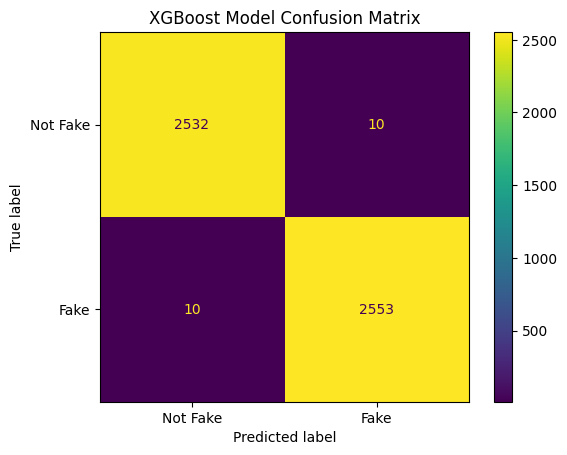

In [14]:
# Confusion Matrix for the Model
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Fake', 'Fake']).plot()
plt.title("XGBoost Model Confusion Matrix")
plt.show()


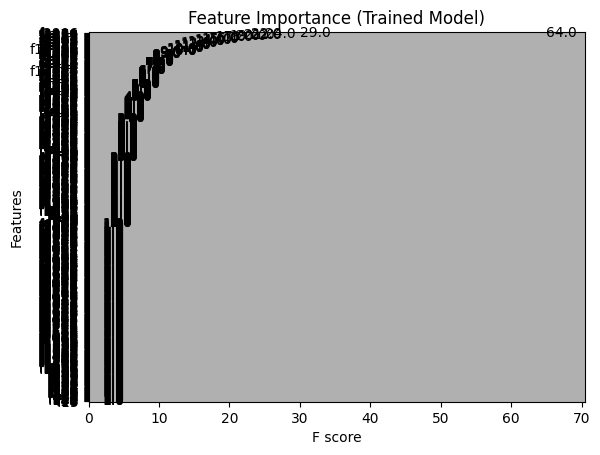

In [15]:
import xgboost

# Visualize Feature Importance
xgboost.plot_importance(model, importance_type="weight")
plt.title('Feature Importance (Trained Model)')
plt.show()


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Load the saved model, vectorizer, and encoder
model = joblib.load('new_xgb_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')
encoder = joblib.load('encoder.pkl')

print("Model, Vectorizer, and Encoder loaded successfully.")


Model, Vectorizer, and Encoder loaded successfully.


In [17]:
# Function to preprocess and predict if a job posting is fake or real
def predict_fake_job(job_data):
    # Prepare text data for vectorization
    combined_text = (job_data['description'] + ' ' +
                     job_data['company_profile'] + ' ' +
                     job_data['requirements'] + ' ' +
                     job_data['benefits'])

    # Vectorize the combined text
    text_features = vectorizer.transform([combined_text])

    # Prepare categorical data for one-hot encoding
    categorical_data = [[
        job_data['employment_type'],
        job_data['required_experience'],
        job_data['required_education'],
        job_data['industry'],
        job_data['function'],
        job_data['location'] + '_' + job_data['industry']
    ]]

    encoded_features = encoder.transform(categorical_data)

    # Combine text and categorical features
    input_combined = hstack([text_features, encoded_features])

    # Check the shape of the input data for compatibility
    print(f"Shape of text_features: {text_features.shape}")
    print(f"Shape of encoded_features: {encoded_features.shape}")
    print(f"Shape of combined input: {input_combined.shape}")

    # Make predictions using the loaded model
    prediction = model.predict(input_combined)
    prediction_prob = model.predict_proba(input_combined)

    # Display the prediction result
    if prediction[0] == 1:
        print("Prediction: The job posting is FAKE.")
    else:
        print("Prediction: The job posting is REAL.")

    # Show the probability score
    print(f"Probability of being FAKE: {prediction_prob[0][1] * 100:.2f}%")


In [18]:
# Example job data to predict if it's fake or real
job_data = {
    'title': 'Vice President, Sales and Sponsorship (Businessfriend.com)',
    'location': 'US, CA, Carlsbad',
    'department': 'Businessfriend.com',
    'salary_range': '100000-120000',
    'company_profile': 'WDM Group is an innovative, forward-thinking digital company aimed at bringing business executives up-to-date with the latest news, information, and trends from across the globe.',
    'description': '#URL_eda2500ddcedb60957fcd7f5b164e092966f8c4e8fb89ce70a16bea1545a297d#, an up and coming social media company, is seeking a VP, Sales and Sponsorship executive...',
    'requirements': 'Job Requirements: A reputation as a "go-getter" and "rainmaker"; Strong interpersonal and leadership abilities...',
    'benefits': 'Businessfriend will offer a competitive six-figure salary for this executive role as well as commission and stock options...',
    'telecommuting': 0,
    'has_company_logo': 1,
    'has_questions': 0,
    'employment_type': 'Full-time',
    'required_experience': 'Executive',
    'required_education': 'Unspecified',
    'industry': 'internet',
    'function': 'Sales'
}

# Run the prediction function
predict_fake_job(job_data)


Shape of text_features: (1, 5000)
Shape of encoded_features: (1, 6598)
Shape of combined input: (1, 11598)
Prediction: The job posting is REAL.
Probability of being FAKE: 0.21%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [19]:
# Random example job data to predict if it's fake or real
job_data = {
    'title': 'Software Engineer',
    'location': 'US, NY, New York',
    'department': 'Engineering',
    'salary_range': '80000-100000',
    'company_profile': 'A leading technology company focused on innovative software solutions for businesses worldwide. We prioritize cutting-edge technology and exceptional customer support.',
    'description': 'We are looking for a skilled Software Engineer to join our dynamic team. You will be responsible for developing high-quality software solutions, collaborating with cross-functional teams, and continuously improving our technology stack. This position requires expertise in Python, JavaScript, and cloud platforms.',
    'requirements': 'Bachelor\'s degree in Computer Science or a related field. 3+ years of software development experience, proficiency in Python and JavaScript, experience with cloud services (AWS, Azure), and excellent problem-solving skills.',
    'benefits': 'Competitive salary, health and dental insurance, 401(k) matching, paid vacation, remote work options, and opportunities for professional development.',
    'telecommuting': 1,
    'has_company_logo': 1,
    'has_questions': 1,
    'employment_type': 'Full-time',
    'required_experience': 'Mid-Senior',
    'required_education': 'Bachelor\'s Degree',
    'industry': 'Technology',
    'function': 'Engineering'
}

# Run the prediction function with the random job example
predict_fake_job(job_data)


Shape of text_features: (1, 5000)
Shape of encoded_features: (1, 6598)
Shape of combined input: (1, 11598)
Prediction: The job posting is REAL.
Probability of being FAKE: 0.06%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [20]:
# Fake example job data to predict if it's fake or real
job_data_fake = {
    'title': 'Get Rich Quick - Work From Home!',
    'location': 'Remote (Anywhere)',
    'department': 'Human Resources',
    'salary_range': '30000-50000',
    'company_profile': 'A mysterious new company that promises to make you a millionaire in no time! We are looking for motivated individuals to join our remote team.',
    'description': 'Do you want to make easy money while working from home? We offer you the chance to earn large commissions by simply referring others to our platform. No experience required, just enthusiasm and willingness to work hard!',
    'requirements': 'No experience necessary, just a desire to work and earn money fast.',
    'benefits': 'Earn unlimited income, work from anywhere, flexible hours, and be your own boss!',
    'telecommuting': 1,
    'has_company_logo': 0,
    'has_questions': 0,
    'employment_type': 'Contract',
    'required_experience': 'None',
    'required_education': 'None',
    'industry': 'Marketing',
    'function': 'Sales'
}

# Run the prediction function with the fake job example
predict_fake_job(job_data_fake)


Shape of text_features: (1, 5000)
Shape of encoded_features: (1, 6598)
Shape of combined input: (1, 11598)
Prediction: The job posting is REAL.
Probability of being FAKE: 4.56%


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
